# Vehicle recognition - Deep learning models training
### Vehicle Classification

This notebook is designed to function both locally and in Google colab, in order to use the processing resources it provides, in this case the T4 gpu.
We start by downloading the data, making a short EDA, preprocessing the data for performance, and then making the models:
1. Multilayer perceptron
2. LeNet
3. Transfer Learning to a Resnet50 model
4. EfficientNetB1 model, obtaining from it the best result.


In [1]:
from imp import reload
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

In [2]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

True

In [3]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
if IN_COLAB:
    # Put here the full path to the folder having your Sprint project code
    # e.g. "/content/drive/MyDrive/assignment"
    ROOT_DIR = "/content/drive/MyDrive/Colab Notebooks/SPR04"
    %cd $ROOT_DIR

/content/drive/MyDrive/Colab Notebooks/SPR04


## Install dependencies (Only for Colab)

In [6]:
if IN_COLAB:
    # This will make sure you have installed all the proper dependencies
    # Instal dependencies
    !pip install -r requirements.txt
    # We can access to GPUs in Colab, so install GPU version of tensorflow
    !pip install tensorflow-gpu==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: pytest
    Found existing installation: pytest 7.4.3
    Uninstalling pytest-7.4.3:


## 1. Introduction

This is a Multi-class Classification task: we want to predict, given a picture of a vehicle, which of the possible 25 classes is the correct vehicle make-model.

The dataset is composed of JPG images, already stored in folders containing the label (vehicle make-model), separated in train and test sets.


In [7]:
!pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 37.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
 

In [8]:
import os

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from src import data_utils, config, models

### Getting the data

To access the data for this project, we can execute the code below. This will download a zip file `cars_25_dataset.zip` containing inside:

- `car_ims_dataset`: Folder whit train and test images, already classified in sub-folders with the corresponding vehicle label.

- `train_dataset_annos.csv` and `test_dataset_annos.csv`: Train and test images annotations provided in CSV file format. 

1.1. Download the training and test datasets.

In [9]:
if IN_COLAB:
    config.DATASET_ROOT_PATH = "/content/dataset/"

data_utils.download_datasets(config.DATASET_ROOT_PATH)

Downloading...
From: https://drive.google.com/uc?id=1ueaI8NJLS73Eq8Kx9ctdy5hK3vD53_Jb&confirm=t
To: /content/dataset/cars_25_dataset.zip
100%|██████████| 116M/116M [00:05<00:00, 22.7MB/s]


1.2. Setup some variables to use during training the model.

In [10]:
# Dataset folder
DATASET_FOLDER = os.path.join(config.DATASET_ROOT_PATH, config.DATASET_FILENAME)
DATASET_FOLDER = os.path.join(config.DATASET_ROOT_PATH, "eu-car-dataset_subset")

img_height = 224
img_width = 224
batch_size = 32

1.3. Load the training and testing images as a Tensorflow dataset (`tf.data.Dataset`).

It's not a good idea to load all the images into memory because they may need more RAM than the one installed in the system. This is why we create generators using the `image_dataset_from_directory()` function, which loads the images only when they are needed and then releases the memory for loading another batch of new images from the disk.


**Don't change anything in this cell, just make it run correctly**

In [11]:
# Load train and test datasets
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(DATASET_FOLDER, "train"),
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(DATASET_FOLDER, "test"),
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 7509 files belonging to 25 classes.
Found 1875 files belonging to 25 classes.


**Checkpoint:** The cell above should output the following message:

```code
Found 7509 files belonging to 25 classes.
Found 1875 files belonging to 25 classes.
```

## 2. Basic EDA

Let's load and display some pictures with their labels.


2.1. Take the class names automatically inferred from the data generator and assign to `class_names` variable. We will use this to do some EDA and also to define the output units in the classification layer of our model.


**Don't change anything in this cell, just make it run correctly**

In [12]:
class_names = train_ds.class_names
print(class_names)

assert len(class_names) == 25

['abarth_595-turismo', 'abarth_grande-punto', 'bmw_z4', 'citroen_c-crosser', 'citroen_ds4', 'citroen_nemo', 'dacia_lodgy', 'ford_f-150', 'hyundai_h-350', 'hyundai_i30', 'land-rover_range-rover-velar', 'mercedes-benz_180', 'mercedes-benz_a-180', 'mercedes-benz_b-220', 'mercedes-benz_cla-220', 'mercedes-benz_cls-320', 'mercedes-benz_slk-350', 'mini_cooper-sd', 'nissan_nv400', 'nissan_primastar', 'peugeot_108', 'porsche_991', 'suzuki_ignis', 'volkswagen_fox', 'volkswagen_up!']


2.2. Let's show some pictures!

You can re-run the following cell as many times as you want and it will always show a new set of images and labels.

**Don't change anything in this cell, just make it run correctly**

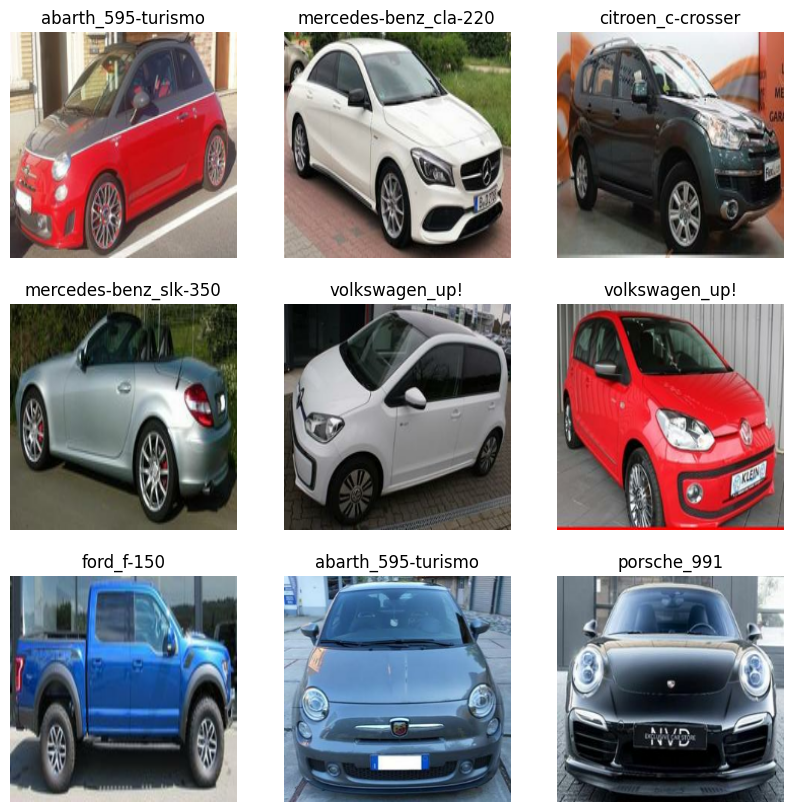

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

**Don't change anything in this cell, just make it run correctly**

In [13]:
# Configure data loader for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 3. Multi-layer Perceptron

*Now it's time to train our first Neural Network model. For simplicity, we are going to try using an MLP model.*

*A Multi-layer Perceptron (MLP) is a simple neural network consisting of multiple layers of nodes connected by weighted edges. The input and output layers have one node per feature, and one node per target class respectively, while the intermediate layers have an arbitrary number of nodes. MLPs are known to work well for simple classification tasks, but they might not be suitable for image classification, where the input data has a high dimensionality and there are correlations between adjacent pixels.*

---

Executing the following cell will create a model using the `create_mlp_model()` functions you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_mlp_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


In [ ]:
reload(models)
mlp_model = models.create_mlp_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# reduce learning rate on plato, early stoping, call back , epochs

mlp_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 512)               77070848  
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 25)                12825     
                                                                 
Total params: 78,133,785
Trainable params: 78,133,785


In [ ]:
mlp_model.save('mlp_model.h5')

At this point the model accuracy in the validation dataset should be around *0.3*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

## 4. CNN: LeNet

*Multi-layer Perceptrons are known to work well for simple classification tasks, but they might not be suitable for image classification, where the input data has a high dimensionality and there are correlations between adjacent pixels.*

*If the previous model wasn't enough for the accuracy we aim to achieve, we can try a bigger one, a Convolutional Network! We are going to use the first develop CNN, the LeNet model.*

*LeNet is a type of Convolutional Neural Network (CNN) that was specifically designed for image classification. LeNet uses a set of convolutional layers to extract low-level features such as edges and corners, and then combines them into higher-level features through a series of pooling layers. Finally, a set of fully connected layers is used to classify the images. LeNet has shown to be very effective in image classification tasks, especially in cases where the input images are small and the features are not too complex.*

---

Executing the following cell will create a model using the `create_lenet_model()` function you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_lenet_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


In [ ]:
reload(models)
lenet_model = models.create_lenet_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
lenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

lenet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 average_pooling2d (AverageP  (None, 111, 111, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 average_pooling2d_1 (Averag  (None, 54, 54, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 46656)             0

At this point the model accuracy in the validation dataset should be around *0.3*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

- at this moment, the val accuracy is stable, maybe if we train more epochs in some point will start to overfit

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

- we could test some changes in the model to try reaching the desired accuracy but, we are doing this work with a more sophisticated model, this one has natural limitations that won't let it reach good metrics.

In [ ]:
lenet_model.save('lenet_model.h5')

## 5. CNN: Transfer learning from ResNet50

*Maybe the LeNet is still no the best choice for our task. Actually, most of the time, when solving image classification problems, the best results are achieved using pre-built CNN architecture pre-trained on imagenet dataset. This process is commonly known as **transfer learning** or **fine-tuning**.*

*ResNet50, is a much deeper CNN that was developed to tackle the problem of vanishing gradients in deep neural networks. ResNet50 is made up of many layers that are organized into blocks, each of which has a set of convolutional layers followed by shortcut connections that allow for the easy flow of information between layers. These shortcut connections help to prevent vanishing gradients and allow the network to learn very deep representations of the input images. This makes ResNet50 ideal for image classification tasks where the input images are complex and large.*

*Therefore, it would be better to use ResNet50 finetuning for image classification tasks, especially if the input images are complex and large, as it has been optimized for this specific task and has shown to be very effective in achieving state-of-the-art results. Additionally, using ResNet50 finetuning means that the model can take advantage of the pre-trained weights on a large dataset, which can lead to faster convergence and better performance on smaller datasets.*

---

Executing the following cell will create a model using the `create_resnet50_model()` function you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_resnet50_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


In [ ]:
reload(models)
resnet50_model = models.create_resnet50_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
resnet50_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = resnet50_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_accuracy',
            factor = 0.2,
            patience = 3,
        ),
        keras.callbacks.ModelCheckpoint(
            filepath='model.{epoch:02d}-{val_loss:.2f}.h5'
        ),
        keras.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True,
        )
    ],
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_1 (Dropout)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 1024)              102761472 
                                                                 
 dense_3 (Dense)             (None, 25)                25625     
                                                                 
Total params: 126,374,809
Trainable params: 102,787,097
Non-trainable params: 23,587,712
_________________________________________________________________
None
Epoch 1/20
235/235 [======

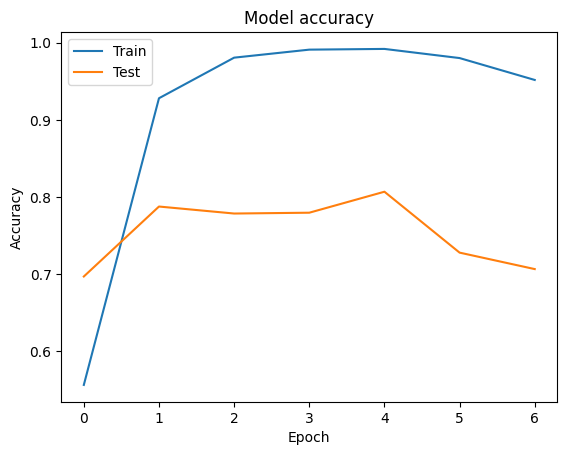

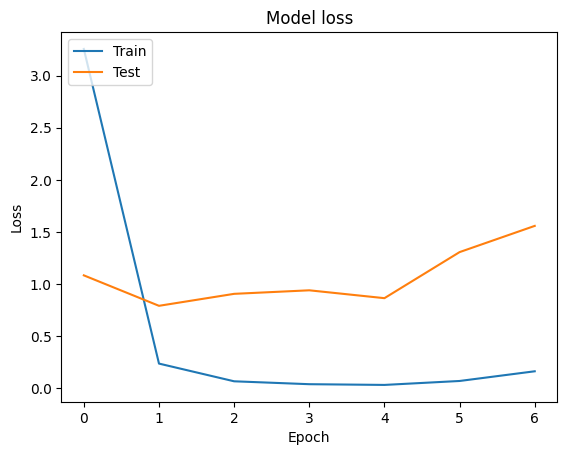

In [ ]:
data_utils.plot_history(history)

At this point the model accuracy in the validation dataset should be around *0.7*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

- The model is starting to overfit, the accuracy in the validation dataset started to increase after getting to 80% accuracy, which is a signal of overfit

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

- We achieved the 80% accuracy with this model adding a dense layer with 1024 neurons, we experimented adding regularization to that layer but the best result was obtained using the dense layer alone.

In [ ]:
resnet50_model.save('resnet_model.h5')

## 6. Analyze model results

Choose your best model and report some metrics on the results you obtained.

You can plot a confussion matrix or use [Scikit-learn classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).


In [14]:
resnet50_model = load_model('resnet_model.h5')

In [18]:
reload(data_utils)

<module 'src.data_utils' from '/content/drive/MyDrive/Colab Notebooks/SPR04/src/data_utils.py'>

59/59 [==============================] - 405s 7s/step

 Classification Report: 

                              precision    recall  f1-score   support

          abarth_595-turismo       0.98      0.74      0.84        80
         abarth_grande-punto       0.66      0.82      0.73        78
                      bmw_z4       0.77      0.85      0.81        80
           citroen_c-crosser       0.81      0.87      0.84        77
                 citroen_ds4       0.80      0.80      0.80        80
                citroen_nemo       0.83      0.97      0.90        80
                 dacia_lodgy       0.87      0.86      0.87        80
                  ford_f-150       0.97      0.94      0.96        80
               hyundai_h-350       0.84      0.70      0.76        46
                 hyundai_i30       0.70      0.54      0.61        80
land-rover_range-rover-velar       0.87      0.95      0.91        43
           mercedes-benz_180       0.34      0.25      0.29        80
        

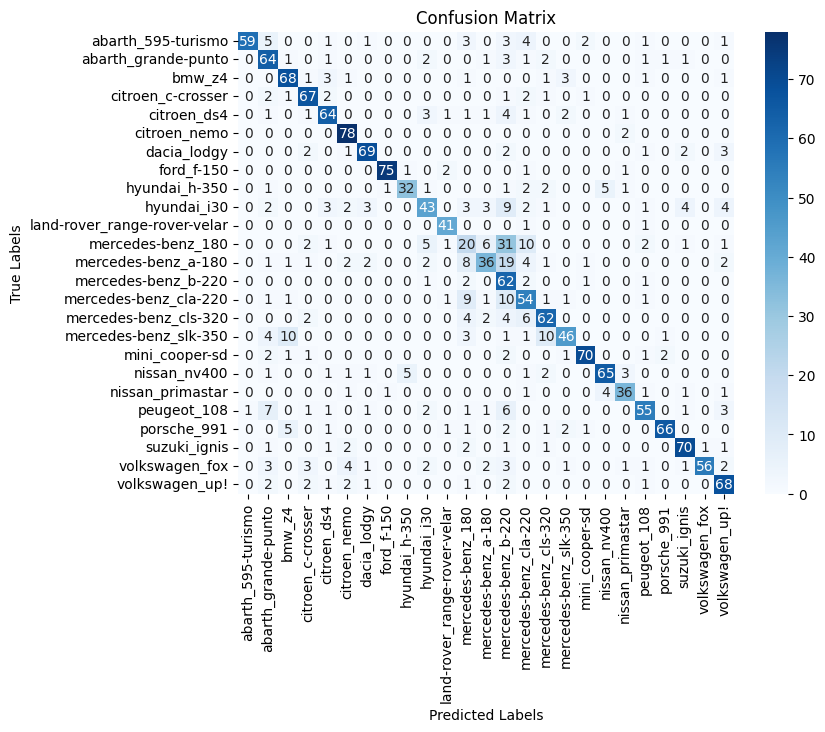

In [19]:
reload(data_utils)
data_utils.evaluate_model(resnet50_model,test_ds,class_names)

## 7. Optional. Make your own model

The models we've trained before are just a limited set over the universe of stuff you can use.

You still have a lot of things to experiment with to increase accuracy, some ideas are:

1. Use any other CNN architecture you think may perform better than ResNet50.
2. Try adding data augmentation or any other regularization algorithms.
3. Train using more epochs, a different optimization algorithm, etc.
4. Check [KerasTuner](https://keras.io/api/keras_tuner/) documentation about how to efficiently test a lot of different architectures and parameters.

#### Strategies to get better results:
* add more layers and test
* add early stopping 
* add regularization with L1 and L2 parameter <-- test with diferent factors for lambda
* change batch size 
* data augmentation?
* change the patience of the early stopping
* dynamic learning rate

# 1. EfficientNetB1 model:
EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks (ICML 2019)


In [ ]:
reload(models)
other_model =  models.create_other_model(input_shape=(img_height, img_width, 3), num_classes=len(class_names))
other_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=5e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='efficientnetb1_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
  )

history = other_model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 20,
    callbacks = [reduce_lr, model_checkpoint]
)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional  (None, 7, 7, 1280)        6575239   
 )                                                               
                                                                 
 flatten_8 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_8 (Dropout)         (None, 62720)             0         
                                                                 
 dense_8 (Dense)             (None, 25)                1568025   
                                                                 
Total params: 8143264 (31.06 MB)
Trainable params: 1568025 (5.98 MB)
Non-trainable params: 6575239 (25.08 MB)
_________________________________________________________________
None
Epoch 1/20


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
235/235 [==============================] - ETA: 0s - loss: 1.6943 - accuracy: 0.6087

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: val_accuracy improved from -inf to 0.76800, saving model to efficientnetb1_model.h5
235/235 [==============================] - 40s 134ms/step - loss: 1.6943 - accuracy: 0.6087 - val_loss: 0.9875 - val_accuracy: 0.7680 - lr: 5.0000e-04
Epoch 2/20
235/235 [==============================] - ETA: 0s - loss: 0.3792 - accuracy: 0.8883
Epoch 2: val_accuracy improved from 0.76800 to 0.79733, saving model to efficientnetb1_model.h5
235/235 [==============================] - 28s 119ms/step - loss: 0.3792 - accuracy: 0.8883 - val_loss: 0.9486 - val_accuracy: 0.7973 - lr: 5.0000e-04
Epoch 3/20
235/235 [==============================] - ETA: 0s - loss:

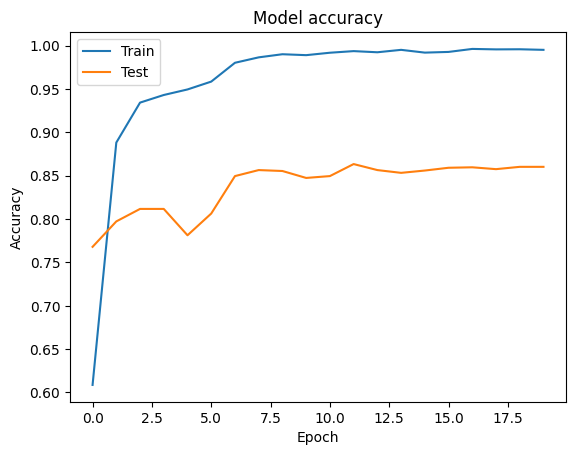

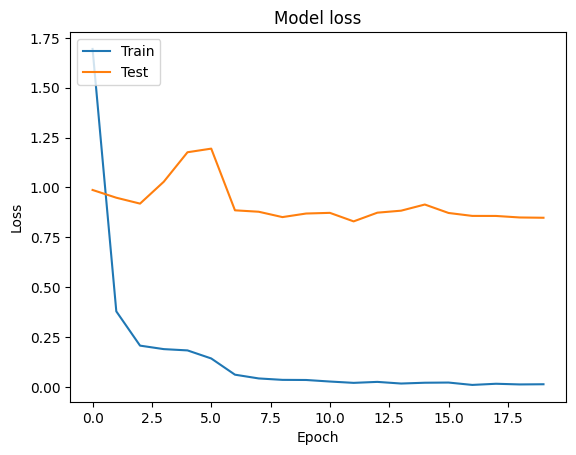

In [ ]:
data_utils.plot_history(history)

# model evaluation

In [20]:
efficientnetb1_model = load_model('efficientnetb1_model.h5')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
59/59 [==============================] - 231s 4s/step

 Classification Report: 

                              precision    recall  f1-score   support

          abarth_595-turismo       0.96      0.89      0.92        80
         abarth_grande-punto       0.88      0.87      0.88        78
                      bmw_z4       0.84      0.89      0.86        80
           citroen_c-crosser       0.96      0.94      0.95        77
                 citroen_ds4       0.91      0.93      0.92        80
                citroen_nemo       0.88      0.99      0.93        80
                 dacia_lodgy       0.96      0.96      0.96        80
               

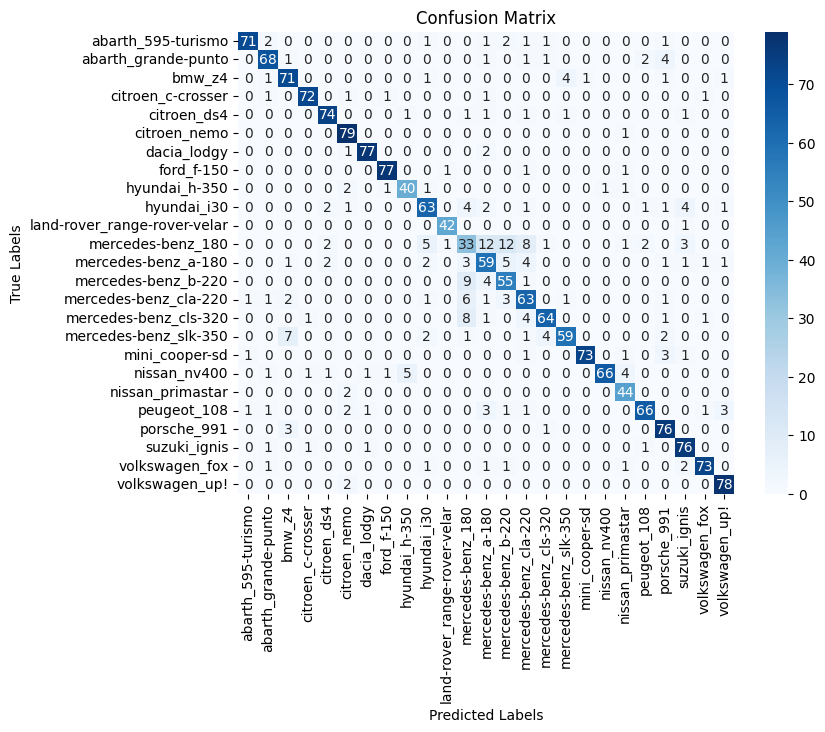

In [21]:
data_utils.evaluate_model(efficientnetb1_model,test_ds,class_names)

## model results

The main problem in classification for both models is in the mercedez benz line, apparently the references are very similar, in the other instances we have maximum 5 misclassification problems between references for example between nissan_nv400 with hyundai_h350.

mercedes-benz_180 is the class with worst metrics, it could be due to its similarity with other references of the same make.

With 86% accuracy in the validation dataset the model behavior is aligned with the desired metric, for future steps we could train the model with more images of the missclassification classes and perform a data augmentation to increase the accuracy.